## Visualization of SeisSol output
### This is is a jupyter notebook for visualizing surface and fault output of SeisSol simulations.

In [1]:
# load module
%matplotlib notebook
# import instaseis
import numpy as np
import matplotlib.pyplot as plt
import h5py

# download from https://pypi.org/project/seissolxdmf/
import seissolxdmf

import pyproj
import scipy.io as sio
import matplotlib.tri as tri
from mpl_toolkits.basemap import Basemap
from scipy import spatial
from netCDF4 import Dataset

print('load successfully!')

load successfully!


In [4]:
# setup projection coordinates. refer to https://epsg.io/
# example: 2021 Chignik, Alaska, earthquake

lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
myproj = pyproj.Proj(proj='geocent', init='EPSG:5936',ellps='WGS84', datum='WGS84')

## prepare trench data, coastline data, hypocenters of earthquakes, if necessary

coastf = 'alaska.mat'
coast = sio.loadmat(coastf)

hypoll = np.loadtxt('hypocenters.dat')
hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)

## folder and model 
modelname = 'tp20m_resampled'
foldername = 'result/'

## initialize seissolxdmf
fn = foldername + modelname +'-fault.xdmf'
# initiate class


<ipython-input-4-bdd74b375eac>:13: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  hypoxyz =  pyproj.transform(lla, myproj,hypoll[:,0],hypoll[:,1],radians=False)


In [50]:
# load surface static GPS displacement and compare

def LoadGPS(foldername, modelname ,gpsfolder,gpsfile):
    
    xdmfFilename = foldername + modelname+'-surface.xdmf'
    sx = seissolxdmf.seissolxdmf(xdmfFilename)

    stall = np.loadtxt(gpsfolder + gpsfile)
    staxyz = pyproj.transform(lla, myproj, stall[:,0],stall[:,1], stall[:,1], radians=False)

    # find stations and read records
    surfxyz = sx.ReadGeometry()
    connect = sx.ReadConnect()
    ndt = sx.ReadNdt()-1

    centers = (surfxyz[connect[:,0]] + surfxyz[connect[:,1]] + surfxyz[connect[:,2]])/3.
    Receiver = np.array([staxyz[0],staxyz[1],staxyz[2]])
    Receiver = Receiver.transpose()

    # search for nearest points of stations
    tree = spatial.KDTree(centers)
    dist, ids = tree.query(Receiver)

    FidReceiversnew = gpsfolder+'/'+'/GPS_xyz.txt'
    fout = open(FidReceiversnew,'w')
    fout1 = open(gpsfolder+'/' +'/GPS_number.txt','w')

    for k in range(0,stall[:,0].size):
            #newrec = find_nearest_vector(centers, rec)
            newrec=centers[ids[k]]
            fout.write("%f %f %f\n" %(newrec[0],newrec[1],newrec[2]))
            fout1.write("%d %f\n" %(ids[k],dist[k]))
    fout.close()
    fout1.close()

    ## read records
    sta = np.loadtxt(gpsfolder+'/GPS_number.txt')
    sta = sta[:,0]
    nsta = sta.size
    vec = np.array([])
    xyz = np.array([])

    for ista in range(0,nsta):
        nEle= np.int(sta[ista])
        uu = sx.ReadData('U',ndt)
        vv = sx.ReadData('V',ndt)
        ww = sx.ReadData('W',ndt)
        slp1 = uu[nEle]
        slp2 = vv[nEle]
        slp3 = ww[nEle]
        vec = np.append(vec,[slp1,slp2,slp3])

    np.savetxt(gpsfolder+'/GPS_vec.txt',vec)

def PlotGPS(foldername,modelname,gpsfolder, gpsfile):
    
    LoadGPS(foldername,modelname,gpsfolder, gpsfile)

    # prepare SeisSol surface outputs
    xdmfFilename = foldername + modelname+'-surface.xdmf'
    sx = seissolxdmf.seissolxdmf(xdmfFilename)
    
    surfxyz = sx.ReadGeometry()
    connect = sx.ReadConnect()
    ndt = sx.ReadNdt()-1
    
    flonlat =  pyproj.transform(myproj,lla,surfxyz[:,0],surfxyz[:,1],radians=False)
    triang2 = tri.Triangulation(flonlat[0],flonlat[1],connect)
    
    ## prepared  coastline data
    ncst = pyproj.transform(lla, myproj, coast['data'][:,0],coast['data'][:,1], radians=False)
    
    stall = np.loadtxt(gpsfolder+gpsfile)
    staxyz = pyproj.transform(lla, myproj, stall[:,0],stall[:,1], stall[:,1], radians=False)
    
    # prepare GPS files
    obv = np.loadtxt(gpsfolder + '/gnss_data.txt');
    model = np.loadtxt(gpsfolder  +'/GPS_vec.txt')  ;
#     data = np.loadtxt(gpsfolder+gpsfile) ;
    
    # obvx = staxyz[0]/1e3
    # obvy = staxyz[1]/1e3
    obvx = stall[:,0]
    obvy = stall[:,1]
    
    nElements = sx.ReadNElements()
    slpz = sx.ReadData('W',ndt)
    slpy = sx.ReadData('V',ndt)
    slpx = sx.ReadData('U',ndt)
    slp = np.sqrt(slpy*slpy+slpx*slpx)
    
    fig,([ax2,ax3])=plt.subplots(ncols=2,nrows=1,figsize=(12,6))

    #sc = ax0.tripcolor(triang,td[0]/1e6,cmap='seismic',shading='flat')
    sc = ax2.tripcolor(triang2,slp,cmap='plasma',shading='flat',vmin=-3.0,vmax=3.0)
    cl = fig.colorbar(sc,ax=ax2,shrink=0.75)
    cl.set_label('horizontal disp. (m)')
    #

    ax2.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.15)
    ax2.set(xlim=(-162, -153.5),ylim=(53,59))
    # ax2.set_title('Simulation')
    ax2.set_yticks([52,54,56,58])
    # ax2.contour(xxx[0]/1e3,xxx[1]/1e3,z)
    ax2.set_aspect(1)

    ax2.quiver(np.append(obvx,-160),np.append(obvy,52.8),np.append(model[0::3]*1000,100),np.append(model[1::3]*1000,0),
               scale=350,scale_units='inches',color='orange',width=0.010)

    ax2.quiver(np.append(obvx,-160),np.append(obvy,52.5),np.append(obv[:,2]*1000,100),np.append(obv[:,3]*1000,0),
               scale=350,scale_units='inches',color='gray',width=0.010)

    ax2.text(-161,53.1,'100 mm')
    ax2.text(-161,52.8,'mod')
    ax2.text(-161,52.5,'obv')

    ##     ax2.set_title('Mapview of GPS vector ')

    sc = ax3.tripcolor(triang2,slpz,cmap='plasma',shading='flat',vmax=3.0,vmin=-3.0)
    cl = fig.colorbar(sc,ax=ax3,shrink=0.75)
    cl.set_label('vertical disp. (m)')
    ##
    # ax3.plot(ncst[0]/1e3,ncst[1]/1e3,'-k',linewidth=0.5)
    # ax3.set(xlim=(0.9e3, 1.8e3),ylim=(-2.5e3,-1.4e3))
    # ax3.plot(hypoll[:,0],hypoll[:,1],'*r',markersize=5)
    ax3.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.15)
    ax3.set(xlim=(-162, -153.5),ylim=(53,59))
    # ax3.set_title('Simulation')
    ax3.set_yticks([52,54,56,58])
    # ax3.contour(xxx[0]/1e3,xxx[1]/1e3,z)

    ax3.quiver(np.append(obvx-0.1,-160),np.append(obvy,52.8),np.append(model[2::3]-model[2::3],100),np.append(model[2::3]*1000,0),
               scale=100,scale_units='inches',color='orange',width=0.010)
    #
    ax3.quiver(np.append(obvx,-160),np.append(obvy,52.5),np.append(obv[:,3]-obv[:,3],100),np.append(obv[:,4]*1000,0),
               scale=100,scale_units='inches',color='gray',width=0.010)
    #
    ax3.text(-161,53.1,'100 mm')
    ax3.text(-161,52.8,'mod')
    ax3.text(-161,52.5,'obv')
    ax3.set_aspect(1)

    outname = modelname +'-gps.png'
    plt.savefig(outname,dpi=150,transparent=False)

In [49]:
def PlotMomentRate(model_EnF,STFfile):
    fin = open(model_EnF,'r')
    enf = np.loadtxt(fin,comments='#',skiprows=1)

#     mfile='STF_usgs_2.txt'
    fin2 = open(STFfile,'r')
    mr2 = np.loadtxt(fin2)

    moment0 = 0.0
    M0 = np.trapz(enf[:,1], x=enf[:,0])
    mag  = 2/3*np.log10(M0)-6.07


    plt.figure(figsize=(4.5,3.5))

    ax0=plt.subplot(111)               
    plt.plot(enf[:,0],enf[:,1]*1e7/1e26,'-',color='red')   # from MPa*m**2/s to dyne-cm/s
    plt.plot(mr2[:,0],mr2[:,1]/1e19,'-',color='k') # normalized by 1e19
#     plt.plot(mr1[:,0],mr1[:,1]/1e19,'--',color=colors2[0]) # normalized by 1e19

    plt.legend(['this study'+ ' Mw'+str(round(mag,2)),'USGS Mw8.2'])

    plt.xlabel('time (s)')
    plt.ylabel('moment rate (*$10^{19}$ Nm/s)')
    ax0.set(xlim=(0,90),ylim=(0,10))

    # seismic moment magnitude

    # plt.text(6,9,'Mw'+str(round(mag,2)),color=colors2[5])
    plt.savefig('moment-mag.png',dpi=150)

In [15]:
def PlotFaultSlip(foldername, modelname,slip_model):
    # load slip model
    data = sio.loadmat(slip_model)
    lon_usgs= data['data']['lon'][0,0]
    lat_usgs= data['data']['lat'][0,0]
    slip_usgs= data['data']['slip'][0,0]

    # print(slip_usgs.shape)

    xdmfFilename = foldername + modelname+'-fault.xdmf'
    sx = seissolxdmf.seissolxdmf(xdmfFilename)
    ndt = sx.ReadNdt()-1
    # ndt=90
    xyz = sx.ReadGeometry()
    connect = sx.ReadConnect()

    flonlat =  pyproj.transform(myproj,lla,xyz[:,0],xyz[:,1],radians=False)
    triang2 = tri.Triangulation(flonlat[0],flonlat[1],connect)

    asl= sx.ReadData('ASl',ndt)

    fig,([ax0,ax1])=plt.subplots(nrows=1,ncols=2,figsize=(9,3))

    #ax0.set_title('Mapview of Td0')
    sc = ax0.tripcolor(triang2,asl,cmap='plasma_r',shading='flat',vmin=0.0,vmax=8.0)
    ax0.plot(hypoll[:,0],hypoll[:,1],'*',color='k',markersize=5)
    ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.2)
    ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
    ax0.set_title('Simulation')
    ax0.set_yticks([53,54,55,56,57])
    # ax0.set_aspect(1)

    cl = fig.colorbar(sc,ax=ax0,shrink=0.65)

    ax1.pcolor(lon_usgs,lat_usgs,slip_usgs,cmap='plasma_r',shading='flat',vmin=0.0,vmax=8.0)
    # ax1.set(xlim=(1.2e3, 1.75e3),ylim=(-2.2e3,-1.6e3))
    ax1.set(xlim=(-160.5,-154),ylim=(53.5,57))
    cl = fig.colorbar(sc,ax=ax1,shrink=0.65)
    ax1.plot(hypoll[:,0],hypoll[:,1],'*',markersize=5,color='k')
    ax1.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.2)
    ax1.set_title('Inversion-USGS')
    cl.set_label('fault slip (m)')
    ax1.set_yticks([53,54,55,56,57])
    # ax1.set_aspect(1)

    outname = modelname +'-slip.png'
    plt.savefig(outname,dpi=100,transparent=False)

In [25]:
def PlotFaultStress(foldername, modelname,ndt):

    # print(slip_usgs.shape)

    xdmfFilename = foldername + modelname+'-fault.xdmf'
    sx = seissolxdmf.seissolxdmf(xdmfFilename)
    # ndt=90

    xyz = sx.ReadGeometry()
    connect = sx.ReadConnect()

    # triangular mesh on the fault
    flonlat =  pyproj.transform(myproj,lla,xyz[:,0],xyz[:,1],radians=False)
    triang2 = tri.Triangulation(flonlat[0],flonlat[1],connect)

    td = sx.ReadData('Td0',ndt)

    fig,ax0=plt.subplots(nrows=1,ncols=1,figsize=(5,3))

    #ax0.set_title('Mapview of Td0')
    sc = ax0.tripcolor(triang2,td/1e6,cmap='plasma_r',shading='flat',vmin=0,vmax=100)
    ax0.plot(hypoll[:,0],hypoll[:,1],'*',color='k',markersize=5)
    ax0.plot(coast['data'][:,0],coast['data'][:,1],'-k',linewidth=0.2)
    
    ax0.set(xlim=(-160.5, -154),ylim=(53.5,57))
    ax0.set_yticks([53,54,55,56,57])
    cl = fig.colorbar(sc,ax=ax0,shrink=0.65)
    cl.set_label('along-dip shear stress (MPa)')

    outname = modelname +'-stress.png'
    plt.savefig(outname,dpi=100,transparent=False)

<IPython.core.display.Javascript object>


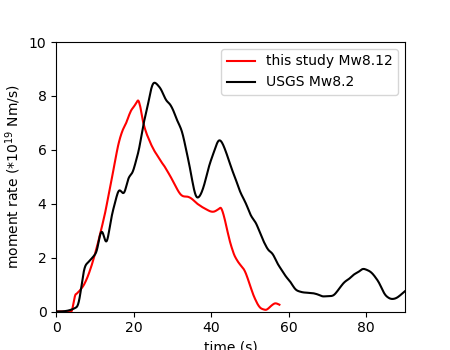

<ipython-input-15-fd6d84e9c18f>:17: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  flonlat =  pyproj.transform(myproj,lla,xyz[:,0],xyz[:,1],radians=False)


<IPython.core.display.Javascript object>


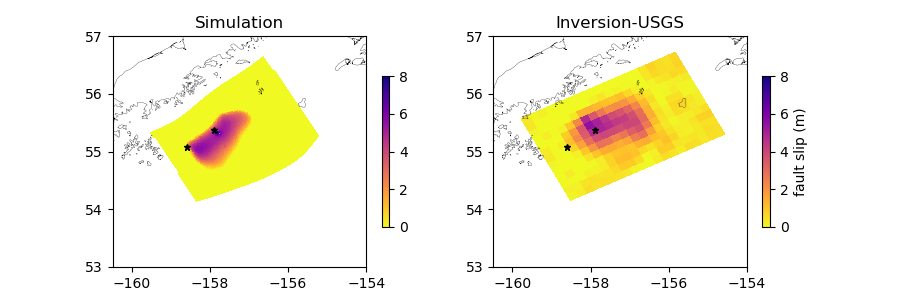

<ipython-input-15-fd6d84e9c18f>:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolor(lon_usgs,lat_usgs,slip_usgs,cmap='plasma_r',shading='flat',vmin=0.0,vmax=8.0)
<ipython-input-50-4e0642b2279b>:9: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  staxyz = pyproj.transform(lla, myproj, stall[:,0],stall[:,1], stall[:,1], radians=False)
<ipython-input-50-4e0642b2279b>:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to spec

<IPython.core.display.Javascript object>


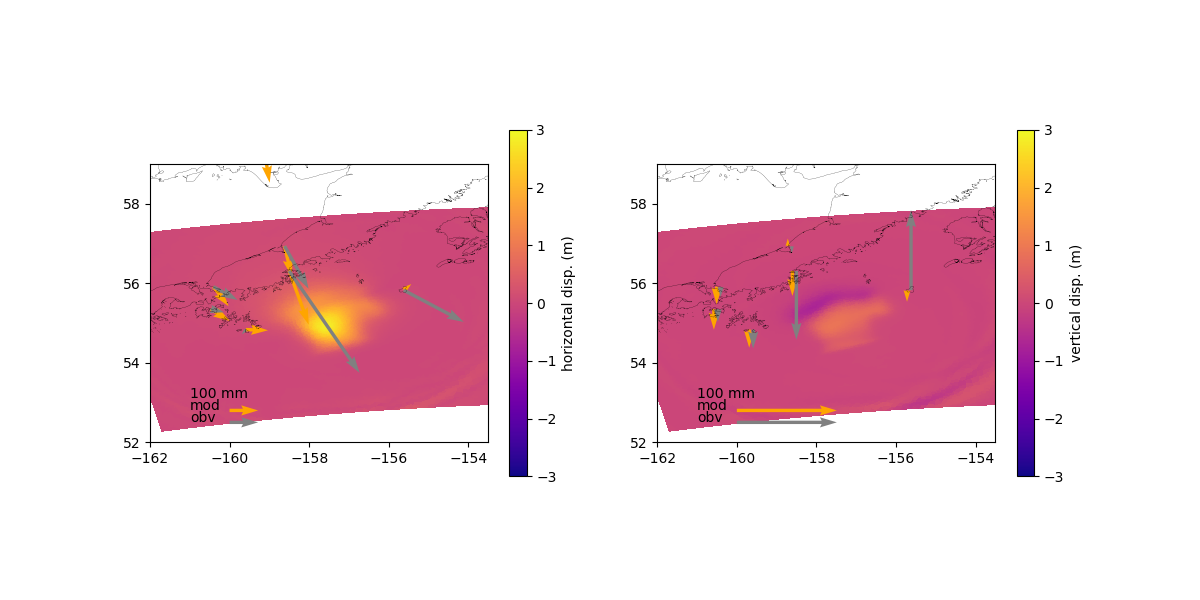

In [51]:
# define model
modelname = 'tp20m_resampled'
foldername = 'result/'

## initialize seissolxdmf
fn = foldername + modelname +'-fault.xdmf'
# initiate class
sx = seissolxdmf.seissolxdmf(fn)

##1. plot moment rate
## need to prepare STF file from USGS: col: time(s) and moment rate
PlotMomentRate('tp20m-EnF_0t-all.dat','STF_usgs_2.txt')

## 2. Plot Fault slip
## need to prepare: kinematic model from USGS 
# exmaple: https://earthquake.usgs.gov/earthquakes/eventpage/ak0219neiszm/finite-fault

PlotFaultSlip(foldername,modelname,'usgs_slip.mat')

# 3. plot final shear stress
# PlotFaultStress(foldername,modelname,0)

## 4. plot surface GPS comparison.
# need to prepare GPS vector from http://geodesy.unr.edu/ or Unavco
PlotGPS(foldername, modelname ,'./','/gnss_station2.txt')

In [ ]:
print('finished!')